<a href="https://colab.research.google.com/github/andreac941/ComputerVision-Eq3/blob/main/1_ENTREGABLE/Equipo20_semana06y07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**6.3 Actividad en Equipos - Semana 6 y 7. Modelado de Temas: LSI/LDA**

Equipo 20:
* Andrea Carolina Treviño Garza A01034993

En la actividad de esta semana trabajarás en equipos en el tema de modelado de temas (topic modeling).

In [33]:
#Líbrerías requeridas para la actividad:
 
#import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import ast
import re

from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

import pickle
import gensim
import gensim.corpora as corpora
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


A continuación se incluyen todas las instalaciones requeridas para la actividad.

In [54]:
#Se instala visualizador de LDA:
!pip install pyldavis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [55]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#Se instalan los requerimientos para realizar la lematización del texto en español.
!pip install spacy_spanish_lemmatizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for spacy_spanish_lemmatizer: filename=spacy_spanish_lemmatizer-0.7-py3-none-any.whl size=10412 sha256=9b77399c03150bd67b7e44e9b384cf32ce2fdee18f047d7c2de82d3ce5d08add
  Stored in directory: /root/.cache/pip/wheels/f1/0f/46/69379c9b1be81b024ef47b671d16d13ffa81c0d9f06cb47b59
Successfully built spacy_spanish_lemmatizer


In [ ]:
#Se instalan otros requerimientos para realizar la lematización del texto en español.
!python -m spacy download es_core_news_md

2023-06-08 01:59:38.270562: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-08 01:59:40.458825: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 9.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')


In [ ]:
#Se instalan otros requerimientos adicionales para realizar la lematización del texto en español.
!python -m spacy_spanish_lemmatizer download wiki

2023-06-08 02:00:30.927378: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-08 02:00:34.226128: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Decompressing dump file: /usr/local/lib/python3.10/dist-packages/spacy_spanish_lemmatizer/tmp/eswiktionary-latest-pages-articles.xml.bz2
Parsing downloaded file...
Generating lemmatization...
Exporting lemmatizer files...
Cleaning temporary files...


In [ ]:
#!pip install gensim --upgrade --user

1. Descarga el archivo noticiasTopicModeling.txt que se encuentra en Canvas. Este archivo consiste en 5658 noticias de varios periódicos de España. El archivo de texto es una lista en el siguiente formato:
[{“titular”:”Encabezado“, “texto”:”Cuerpo”}, … , {“titular”:”Encabezado”,”texto”:”Cuerpo”}]
* Donde “titular” es el encabezado de la noticia y “texto” es el cuerpo del texto de dicha noticia. En particular en esta actividad trabajarás solamente con los cuerpos de las noticias, sin incluir los encabezados. Carga dicho archivo y genera un DataFrame de Pandas llamado “df” y que contiene una única columna llamada “noticia” con 5658 renglones formados por los cuerpos de las noticias.

In [2]:
with open('noticiasTopicModeling.txt', 'r') as fp:
  data = fp.read()
  details = ast.literal_eval(data)

list_texto = []
for x in details:
  list_texto.append(x["texto"])

df =pd.DataFrame(list_texto, columns=['noticia'])
print('Total de registros de noticias', df.shape)

Total de registros de noticias (5658, 1)


2. Realiza un proceso de limpieza. Aplica el preprocesamiento que consideres adecuado para texto en español. Recuerda que el objetivo es identificar los tokens que describan mejor la distribución de cada tema.

In [3]:
#Se guardan las Stopwords en español de archivo de texto "spanish.txt" en lista my_stopwords:
with open('spanish.txt', 'r', encoding= 'utf8') as fp1:
  stopwords = fp1.readlines()
fp1.close()

my_stopwords = []
for p in stopwords:
  my_stopwords.append(re.sub(r'\n','',p))
print("Total de stopwords en español:",len(my_stopwords))
my_stopwords[0:5]

Total de stopwords en español: 608


['a', 'actualmente', 'adelante', 'además', 'afirmó']

In [4]:
#Se define función para proceso de limpieza y tokenización:
def clean_tok(doc):
  tokens = []
  global t1
  t1 = re.findall(r"[A-Za-záéíóúüñÁÉÍÓÚÜÑ]{3,}",doc)
  for i in t1:
    i = i.lower()
    if i not in my_stopwords:     
      tokens.append(i.lower())
  return tokens

In [5]:
#Se aplica función de limpieza y tokenización:
I = df.noticia
cleantok = [clean_tok(i) for i in I]

In [ ]:
#Se visualizan primeros 5 resultados de limpieza y tokenización:
for x in cleantok[0:5]:
  print(x)

['españa', 'dejado', 'católica', 'decía', 'manuel', 'azaña', 'comienzo', 'república', 'congreso', 'diputados', 'aprobó', 'leyes', 'laicistas', 'metáfora', 'católica', 'papel', 'ley', 'creencias', 'pueblo', 'migración', 'integración', 'europea', 'programa', 'vox', 'europa', 'españa', 'domingo', 'noviembre', 'dejado', 'excepción', 'europa', 'potencia', 'extrema', 'derecha', 'parlamento', 'metáfora', 'precisamente', 'excepcional', 'dictadura', 'mediados', 'setenta', 'dictador', 'mausoleo', 'años', 'muerto', 'existía', 'cosa', 'portugal', 'grecia', 'italia', 'alemania', 'países', 'dictaduras', 'fascistas', 'españa', 'pasó', 'portugal', 'italia', 'alemania', 'derrotó', 'fascismo', 'franquismo', 'murió', 'cama', 'harakiri', 'cortes', 'franquistas', 'ruptura', 'régimen', 'reforma', 'nació', 'país', 'país', 'mutó', 'ley', 'ley', 'aun', 'españa', 'parecía', 'vacunada', 'años', 'franquismo', 'bastantes', 'llegado', 'irrupción', 'posfranquismo', 'actores', 'fundamentales', 'gobiernos', 'autonómic

In [ ]:
#Se define función para Lematización en español:
import spacy
import spacy_spanish_lemmatizer
from spacy.lang.es.examples import sentences 
nlp = spacy.load("es_core_news_md") #es_core_news_sm

def clean_doc1(doc1):
  tokens = []
  nlp.replace_pipe("lemmatizer", "spanish_lemmatizer")
  tmp1 = ' '.join(doc1)
  for n in nlp(tmp1):
    tokens.append(n.lemma_)
  return tokens

In [ ]:
#Se aplica Lematización y se guarda resultado en clean1: - tarda más de 40 min
clean1 = [clean_doc1(r) for r in cleantok]
clean1[0]

['españa',
 'dejado',
 'católico',
 'decir',
 'manuel',
 'azaña',
 'comienzo',
 'república',
 'congreso',
 'diputados',
 'aprobar',
 'ley',
 'laicistas',
 'metáfora',
 'católico',
 'papel',
 'ley',
 'creencias',
 'pueblo',
 'migración',
 'integración',
 'europeo',
 'programa',
 'vox',
 'europa',
 'españa',
 'domingo',
 'noviembre',
 'dejar',
 'excepción',
 'europa',
 'potencia',
 'extrema',
 'derecho',
 'parlamento',
 'metáfora',
 'precisamente',
 'excepcional',
 'dictadura',
 'mediados',
 'setenta',
 'dictador',
 'mausoleo',
 'año',
 'muerto',
 'existir',
 'cosa',
 'portugal',
 'grecia',
 'italia',
 'alemania',
 'países',
 'dictaduras',
 'fascista',
 'españa',
 'pasar',
 'portugal',
 'italia',
 'alemania',
 'derrotar',
 'fascismo',
 'franquismo',
 'morir',
 'cama',
 'harakiri',
 'corte',
 'franquista',
 'ruptura',
 'régimen',
 'reforma',
 'nacer',
 'país',
 'país',
 'mutar',
 'ley',
 'ley',
 'aun',
 'españa',
 'parecer',
 'vacunado',
 'año',
 'franquismo',
 'bastante',
 'llegado',
 'i

In [ ]:
#Se va a guardar listado de tokens limpios con lematización en español aplicada en formato pickle:

with open("clean1.pickle", "wb") as file:
  pickle.dump(clean1, file, pickle.HIGHEST_PROTOCOL)

3. ¿Por qué en este caso no requerimos hacer una partición en entrenamiento, validación y prueba?

In [ ]:
#Porque es un modelo No supervisado, no tenemos datos etiquetados, con los que podamos tener data leakage

##**Parte 1: Indexación semántica latente (LSI):**

4. Encontrar la matriz Tf-idf de la columna de noticias. Despliega los primeros 5 renglones con algunas de sus columnas con sus nombres, donde las columnas son los tokens. ¿Cuál es el significado de cada renglón? ¿Y el significado de cada columna?

In [6]:
#Se carga formato con "token limpios":
with open("clean1.pickle", "rb") as file:
  load_clean1 = pickle.load(file)

print(list(load_clean1[0]))

['españa', 'dejado', 'católico', 'decir', 'manuel', 'azaña', 'comienzo', 'república', 'congreso', 'diputados', 'aprobar', 'ley', 'laicistas', 'metáfora', 'católico', 'papel', 'ley', 'creencias', 'pueblo', 'migración', 'integración', 'europeo', 'programa', 'vox', 'europa', 'españa', 'domingo', 'noviembre', 'dejar', 'excepción', 'europa', 'potencia', 'extrema', 'derecho', 'parlamento', 'metáfora', 'precisamente', 'excepcional', 'dictadura', 'mediados', 'setenta', 'dictador', 'mausoleo', 'año', 'muerto', 'existir', 'cosa', 'portugal', 'grecia', 'italia', 'alemania', 'países', 'dictaduras', 'fascista', 'españa', 'pasar', 'portugal', 'italia', 'alemania', 'derrotar', 'fascismo', 'franquismo', 'morir', 'cama', 'harakiri', 'corte', 'franquista', 'ruptura', 'régimen', 'reforma', 'nacer', 'país', 'país', 'mutar', 'ley', 'ley', 'aun', 'españa', 'parecer', 'vacunado', 'año', 'franquismo', 'bastante', 'llegado', 'irrupción', 'posfranquismo', 'actor', 'fundamental', 'gobierno', 'autonómico', 'local

In [7]:
#Con método "join" se juntan nuevamente palabras "limpias" de cada noticia:
ddf = []
for c in load_clean1:
  tmp = ' '.join(c)
  ddf.append(tmp)
ddf

ddf[0]

'españa dejado católico decir manuel azaña comienzo república congreso diputados aprobar ley laicistas metáfora católico papel ley creencias pueblo migración integración europeo programa vox europa españa domingo noviembre dejar excepción europa potencia extrema derecho parlamento metáfora precisamente excepcional dictadura mediados setenta dictador mausoleo año muerto existir cosa portugal grecia italia alemania países dictaduras fascista españa pasar portugal italia alemania derrotar fascismo franquismo morir cama harakiri corte franquista ruptura régimen reforma nacer país país mutar ley ley aun españa parecer vacunado año franquismo bastante llegado irrupción posfranquismo actor fundamental gobierno autonómico local ciudadano españa dejar excepción alianza popular manuel fraga beber franquismo sociológico fuerza blas piñar búnker franquista franquismo sociológico mantener tiempo vox escisión españa reinstauración democrático existido fuerza extrema derecho voto escaños fenómeno pas

In [8]:
#Se genera matriz Tf-idf a partir de documentos "limpios":
tfidf = TfidfVectorizer(max_df=2, min_df=1)

tfidf_sparse = tfidf.fit_transform(ddf)

In [10]:
#Se despliegan 1eros 5 renglones de matriz:
tfidf_dense = pd.DataFrame(tfidf_sparse.toarray(), columns=tfidf.get_feature_names_out()) 

print(tfidf_dense.iloc[0:5,35:46])

   abandoné  abandonéis  abandonó  abandó  abanto  abar  abarcas  abarcó  \
0       0.0         0.0       0.0     0.0     0.0   0.0      0.0     0.0   
1       0.0         0.0       0.0     0.0     0.0   0.0      0.0     0.0   
2       0.0         0.0       0.0     0.0     0.0   0.0      0.0     0.0   
3       0.0         0.0       0.0     0.0     0.0   0.0      0.0     0.0   
4       0.0         0.0       0.0     0.0     0.0   0.0      0.0     0.0   

   abardela  abarrategui  abarrotes  
0       0.0          0.0        0.0  
1       0.0          0.0        0.0  
2       0.0          0.0        0.0  
3       0.0          0.0        0.0  
4       0.0          0.0        0.0  


In [11]:
tfidf_dense.shape

(5658, 44140)

In [ ]:
#Agregar respuesta a pregunta: renglones - corresponden a cada noticia, columnas a cada palabra diferente de vocabulario de todas las noticias.

5. Aplica el método de descomposición de valores singulares truncado a la matriz Tf-idf anterior con 10 componentes y obtener el gráfico de la importancia relativa de estas.

In [12]:
# Se define el objeto que aplicará SVD truncada con r=10 valores singulares o tópicos a generar:
r = 10
lsi_obj = TruncatedSVD(n_components = r, 
                       n_iter=100,  
                       random_state=42)

tfidf_lsi = lsi_obj.fit_transform(tfidf_sparse)
Sigma = lsi_obj.singular_values_
V_T = lsi_obj.components_.T     

In [13]:
#Se obtiene valor de importancia de cada componente:
sigmas = lsi_obj.singular_values_

sigmas

array([1.41421356, 1.41421356, 1.41421356, 1.41421356, 1.41421356,
       1.41421356, 1.41421356, 1.41421356, 1.41421356, 1.41421356])

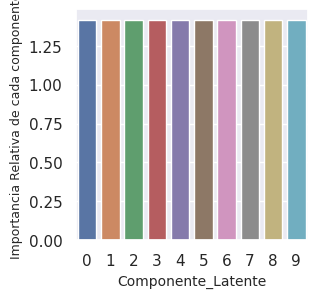

In [14]:
#Se obtiene gráfico de importancia relativa de cada componente
sns.set(rc={'figure.figsize':(3,3)}) 
chart = sns.barplot(x=list(range(len(Sigma))), y = Sigma )
chart.set_xlabel('Componente_Latente', fontdict={'size': 10})
chart.set_ylabel('Importancia Relativa de cada componente', fontdict={'size': 9})
plt.show()

6. Obtener la matriz tokens-temas (term-topic) a partir de la matriz 𝑉􀯍 de la descomposición SVD. Despliega sus primeros 5 renglones donde se incluya el nombre de las columnas.

In [15]:
#La matriz V-transpuesta es la que genera la relación Terms(word)-Topics, los renglones son los términos/words y las columnas los tópicos/temas:
lsi_term_topic = V_T 

print(lsi_term_topic.shape)

(44140, 10)


In [16]:
#Se guardan los nombres de los tokens y generamos un DataFrame con la matriz term-topic:
term_names = list(tfidf.get_feature_names_out())

term_topic_matrix = pd.DataFrame(data=lsi_term_topic, 
                                 index = term_names,   
                                 columns = [f'Concepto_Latente_{r}' for r in range(0,V_T.shape[1])]
                                )

print(term_topic_matrix.shape)   #  words X topics

(44140, 10)


In [17]:
#Se despliegan los primeros 5 renglones de matriz:
term_topic_matrix.head()

,Concepto_Latente_0,Concepto_Latente_1,Concepto_Latente_2,Concepto_Latente_3,Concepto_Latente_4,Concepto_Latente_5,Concepto_Latente_6,Concepto_Latente_7,Concepto_Latente_8,Concepto_Latente_9
aaas,1.424755e-12,5.808071e-12,-8.636989e-12,-1.039233e-11,-9.816664e-12,-1.795191e-12,-3.740662e-12,4.457888e-12,-3.340221e-12,-4.352597e-12
aac,1.471745e-16,3.484967e-16,1.047897e-16,-1.587946e-16,7.694228e-16,9.944315e-17,-1.726789e-16,-4.335490e-16,2.363425e-16,8.342789e-16
aahjko,-8.897317e-14,-1.222633e-13,-3.646194e-14,-2.238659e-15,-5.602739e-14,-1.402252e-13,6.755523e-14,1.375580e-12,1.886082e-12,1.497398e-12
aai,-3.962811e-13,-1.649953e-12,-7.359474e-13,6.168610e-13,-3.883413e-12,-1.627422e-12,2.034164e-12,-3.910251e-13,5.295598e-12,8.017196e-12
aaim,-4.695466e-12,-2.477449e-12,-9.979799e-13,-4.718187e-13,2.974323e-12,7.985503e-13,7.342485e-14,-2.166935e-12,3.373874e-12,1.505468e-12


7. Con base a la cantidad de conceptos latentes que determinaste en el ejercicio 6 anterior, obtener cada uno de sus gráficos con sus 10 términos/tokens más importantes. ¿Cómo describirías cada uno de dichos conceptos latentes?

In [18]:
#NOTA: profesor mandó correo indicando que preguntas 7 y 8 se consideran como una misma pregunta.

8. Para cada uno de los 10 conceptos latentes obtenidos con la descomposición SVD del ejercicio 5, obtener el gráfico de barras que muestre los 10 términos/tokens más importantes de cada uno de ellos.

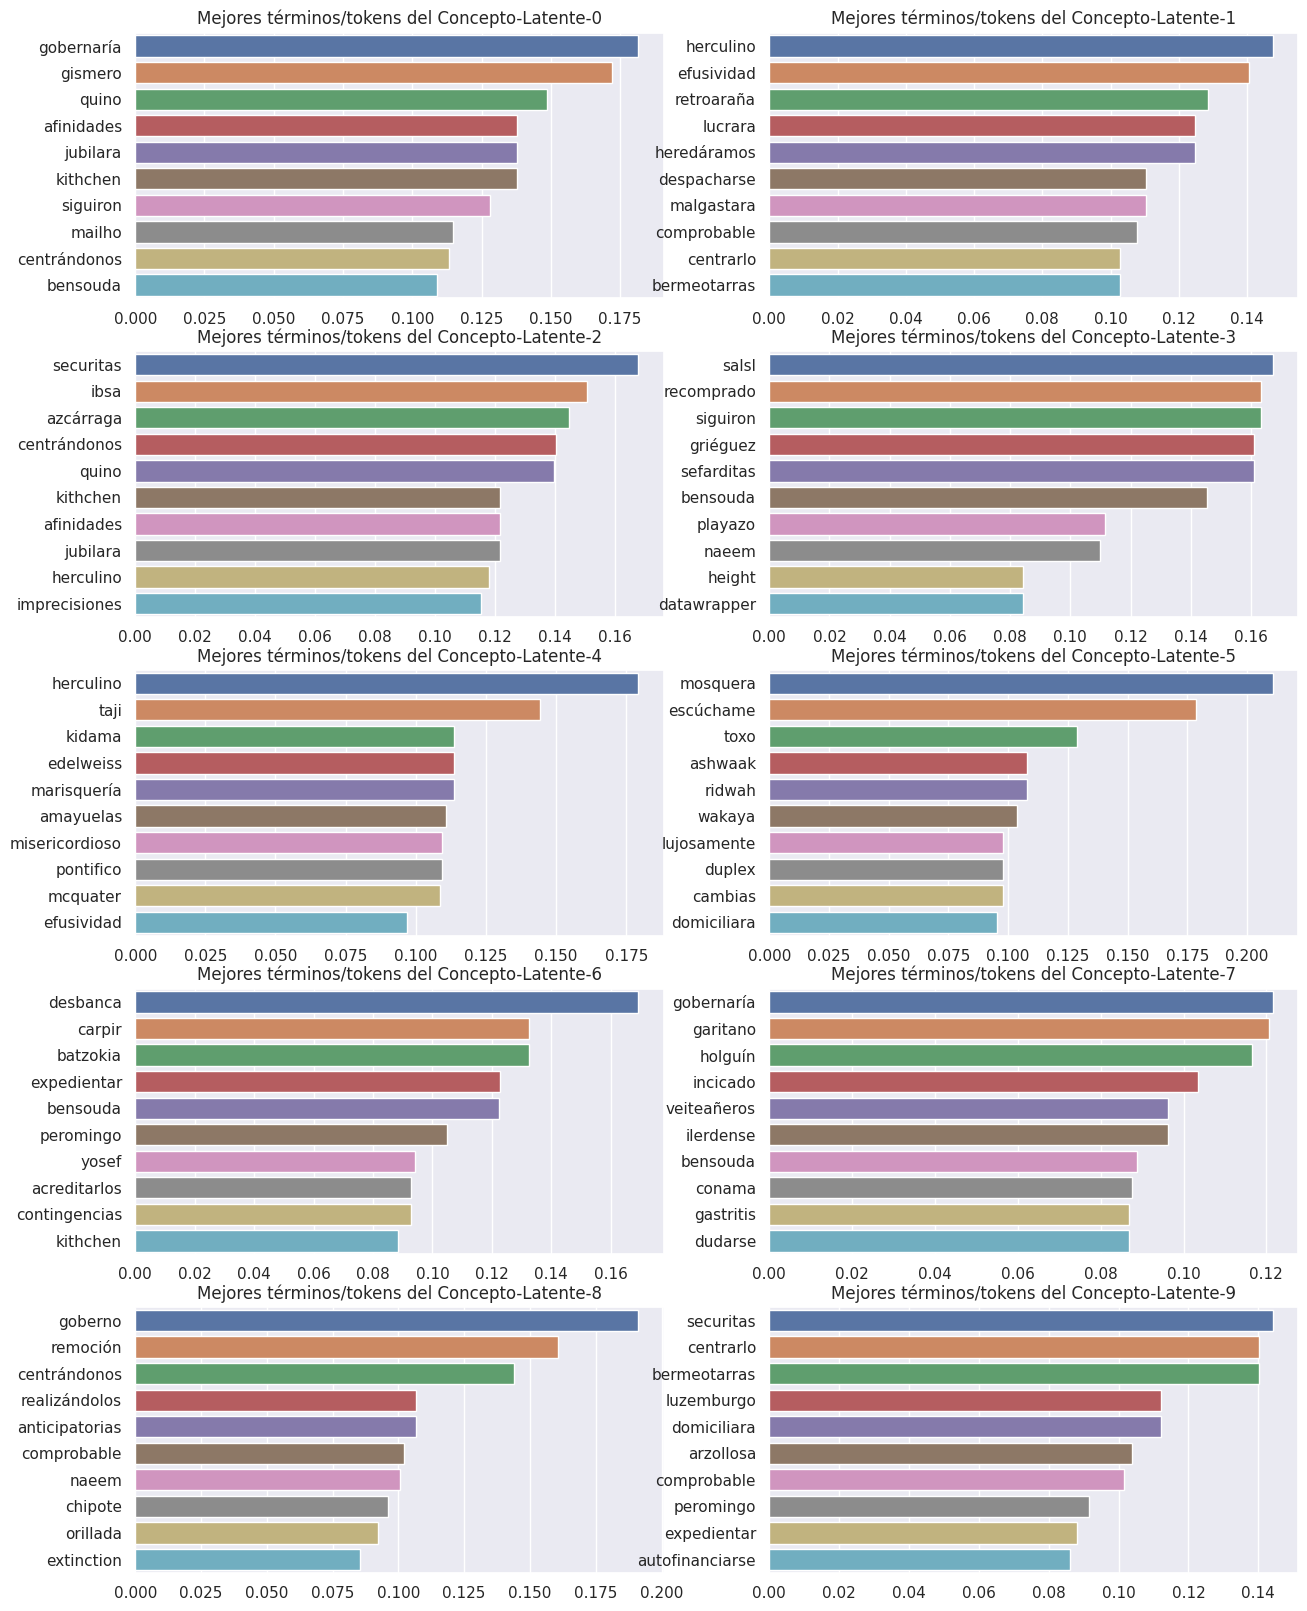

In [19]:
#Se crean listas con los nombres de cada título y variables requeridas para generar graficos de barras de cada concepto latente (en subplots de 5x2):

sns.set(rc={'figure.figsize':(15,20)}) 
top_w = 10 
titles = ['Mejores términos/tokens del Concepto-Latente-'+str(i) for i in range(0,10)]
dataN = ["data"+str(i) for i in range(0,10)]
Con_Lat = ["Concepto_Latente_"+str(i) for i in range(0,10)]
top_w_matrixN = ["top_w_matrix"+str(i) for i in range(0,10)]
new_top = []

for i in range(0,10):
  dataN[i] = term_topic_matrix[Con_Lat[i]]
  dataN[i] = dataN[i].sort_values(ascending=False)
  top_w_matrixN[i] = dataN[i][:top_w]
  plt.subplot(5,2,i+1)
  fig = sns.barplot(x= top_w_matrixN[i].values, y=top_w_matrixN[i].index)
  plt.title(titles[i])
plt.show()


9. Con base a los resultados del ejercicio anterior, ¿cuántos tópicos o conceptos latentes identificas con claridad? ¿Cómo los describirías, es decir, de qué temáticas estarían hablando?

In [ ]:
#

10. La librería de código abierto Gensim, incluye la implementación de la técnica LSI. Ver
documentación: https://radimrehurek.com/gensim/models/lsimodel.html
* Investiga la documentación de este modelo LSI en Gensim y aplica dicha técnica a tu conjunto de
datos. En particular, obtener los modelos de 2 a 10 temas/tópicos y para cada uno de ellos obtener su valor (score) de coherencia. Con base a dichos valores, ¿qué cantidad de tópicos sería el adecuado? ¿Coincide con lo que obtuviste previamente, usando la técnica SVD de manera directa?

In [20]:
mi_dicc = corpora.Dictionary(load_clean1)     # generamos el diccionario

bow = [mi_dicc.doc2bow(doc) for doc in load_clean1]   # y luego la BOW

In [ ]:
#Tarda en correr aprox. 11 min por cada valor i "número de clusters para calcular métrico de coherencia" - 12*11 = más de 132 min --> 2 horas y 12 min.
for i in range(2,15):
    
    lsi = LsiModel(bow, 
                   num_topics=i, 
                   id2word=mi_dicc,
                   chunksize=6,
                   random_seed=7
                  )     
    
    cm = CoherenceModel(model=lsi, 
                        texts=load_clean1, 
                        dictionary=mi_dicc, 
                        window_size=3,
                        coherence='c_v',
                        topn = 3
                       )
    
    cs = cm.get_coherence()
    
    print('Métrica de Coherencia con {} clusters: {}'.format(i, cs))

Métrica de Coherencia con 2 clusters: 0.5397509434606274
Métrica de Coherencia con 3 clusters: 0.6382291618731971
Métrica de Coherencia con 4 clusters: 0.6780883884616733
Métrica de Coherencia con 5 clusters: 0.6459251896550811
Métrica de Coherencia con 6 clusters: 0.6780494430703934
Métrica de Coherencia con 7 clusters: 0.6542588980244053
Métrica de Coherencia con 8 clusters: 0.571209305413303
Métrica de Coherencia con 9 clusters: 0.5932311677895086
Métrica de Coherencia con 10 clusters: 0.6179837796751416
Métrica de Coherencia con 11 clusters: 0.6185898573882661
Métrica de Coherencia con 12 clusters: 0.5847670767891101
Métrica de Coherencia con 13 clusters: 0.5975217806489033
Métrica de Coherencia con 14 clusters: 0.5762485233395297


In [47]:
best_Nclusters = 4 #6, 7

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
# Seleccionas el mejor de los anteriores: - Tardó más de 40 min

lsi = LsiModel(bow, 
               num_topics=best_Nclusters, 
               id2word=mi_dicc,
               chunksize=1024,
               random_seed=7
               )

# Veamos la manera en que se distribuyen los términos en cada tópico generado:
for topic_num, words in lsi.print_topics(num_words=10):
    print('Tokens/Words in Topic {}: {}.'.format(topic_num, words))

Tokens/Words in Topic 0: 0.233*"gobierno" + 0.232*"caso" + 0.208*"persona" + 0.198*"año" + 0.194*"día" + 0.167*"coronavirus" + 0.135*"españa" + 0.132*"madrid" + 0.121*"político" + 0.112*"comunidad".
Tokens/Words in Topic 1: -0.267*"coronavirus" + -0.255*"caso" + -0.229*"persona" + 0.222*"partido" + 0.202*"político" + 0.201*"gobierno" + 0.158*"año" + -0.156*"síntoma" + -0.128*"covid" + -0.116*"día".
Tokens/Words in Topic 2: 0.280*"madrid" + 0.266*"gobierno" + 0.242*"caso" + -0.233*"año" + 0.199*"comunidad" + -0.195*"mujer" + -0.168*"persona" + 0.133*"partido" + -0.131*"casa" + 0.118*"sanidad".
Tokens/Words in Topic 3: -0.507*"caso" + 0.283*"gobierno" + -0.241*"villarejo" + -0.203*"policía" + -0.156*"número" + -0.140*"comisario" + 0.131*"madrid" + 0.129*"coronavirus" + -0.117*"investigación" + -0.102*"juez".
Tokens/Words in Topic 4: 0.453*"non" + 0.293*"goberno" + 0.234*"país" + 0.222*"unha" + 0.168*"galicia" + 0.142*"hai" + -0.121*"empresa" + 0.120*"máis" + -0.112*"euro" + 0.110*"políti

##**Parte 2: Asignación de Dirichlet Latente (LDA):**

11. Utiliza la librería Gensim para implementar ahora la técnica de LDA. Revisa la documentación correspondiente y aplica de preferencia el modelo paralelizable:
* https://radimrehurek.com/gensim/models/ldamodel.html
* https://radimrehurek.com/gensim/models/ldamulticore.html

In [43]:
# generamos el diccionario:

id2word = corpora.Dictionary(load_clean1)
for id in range(5):
    print(id2word[id])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


abascal
abril
actor
afd
alemania


In [44]:
#Se genera corpus con tuplas de índice y frecuencia:
corpus = [id2word.doc2bow(doc) for doc in load_clean1]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [48]:
#Se genera modelo LDA con librería gensim:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, # Tardó más de 8 min.
                    id2word=id2word,
                    num_topics=best_Nclusters,      # total de tópicos que deseas buscar...
                    chunksize=1024,    # número de documentos a analizar en cada chunk de entrenamiento
                    passes=10,        # número de pasadas al corpus durante el entrenamiento.
                    alpha=0.2,        # alfa: similaridad document-topics
                    eta=0.2,         # beta: similaridad topic-words      
                    )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [49]:
lda_model.print_topics(num_topics= best_Nclusters, num_words=10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.007*"caso" + 0.005*"año" + 0.005*"policía" + 0.004*"euro" + 0.004*"político" + 0.004*"investigación" + 0.004*"gobierno" + 0.003*"juez" + 0.003*"empresa" + 0.003*"civil"'),
 (1,
  '0.013*"gobierno" + 0.009*"partido" + 0.009*"político" + 0.005*"presidente" + 0.005*"derecho" + 0.004*"casado" + 0.004*"sánchez" + 0.004*"acuerdo" + 0.004*"psoe" + 0.004*"elección"'),
 (2,
  '0.010*"coronavirus" + 0.009*"caso" + 0.008*"persona" + 0.007*"día" + 0.006*"comunidad" + 0.005*"madrid" + 0.005*"centro" + 0.005*"gobierno" + 0.005*"pandemia" + 0.004*"medido"'),
 (3,
  '0.007*"año" + 0.005*"mujer" + 0.003*"persona" + 0.003*"vida" + 0.003*"historia" + 0.003*"mundo" + 0.003*"día" + 0.002*"hablar" + 0.002*"forma" + 0.002*"etiqueta"')]

12. Con base a esta técnica ¿qué cantidad de tópicos consideras que es la más adecuada? Compara tus
resultados con el método LSI. ¿Qué encuentras de coincidencias y diferencias? ¿Cuál consideras
puede ser el mejor resultado, es decir, cuál consideras puede ser la mejor cantidad de tópicos a
considerar?

In [ ]:
#Seleccionar mejor cantidad de tópicos

13. La librería pyLDAvis nos ayuda a visualizar de manera interactiva los temas y tokens de los documentos analizados. Revisa la documentación y utilízala para visualizar tus mejor resultado.
* https://pypi.org/project/pyLDAvis/

In [57]:
lda_viz = gensimvis.prepare(lda_model, corpus, id2word)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
pyLDAvis.display(lda_viz)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [53]:
#Evidencias de grupo de palabras en excel LDA_VISUALIZATIONS - TÓPICOS IDENTIFICADOS SEGÚN CANTIDAD DE TÓPICOS EN bets_Nclusters

# N=4
#Tópico 1: Economía en España
#Tópico 2: Salud y pandemia 2020 / Social / Local
#Tópico 3: Política en España
#Tópico 4: Cultura / Arte

# N=6
#Tópico 1: Salud y pandemia 2020
#Tópico 2: Economía en España
#Tópico 3: Arte y cultura
#Tópico 4: Local en España (policía)
#Tópico 5: Política en España
#Tópico 6: Violencia hacia mujeres / Abuso sexual / Comunidad LGTBT

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


14. Incluye tus conclusiones finales de la actividad.

###**Conclusiones:**

* Se con..

NOTA: Esta actividad está distribuida en 2 semanas. Aunque la primera parte de esta actividad se
considera para evaluar la primera semana y la segunda parte para la segunda semana, la entrega de toda la
actividad será hasta el final de la segunda semana en un solo documento. Al hacer la evaluación de la
actividad se distribuirán las calificaciones en cada semana.